# EDA_F1_Driver_Constructor

**Objetivo:** Explorar el conjunto de datos de Fórmula 1 (Ergast/Kaggle) para caracterizar la distribución de resultados, relaciones entre variables y asegurar que no existan fugas de información antes del modelado de la influencia piloto–constructor.

**Contenido:**
- Carga y descripción de archivos (`races`, `drivers`, `constructors`, `results`, `qualifying`, `lap_times`, `pit_stops`, `driver_standings`, `constructor_standings`).
- Unión y limpieza (excluir DNF, claves consistentes).
- Distribución de posiciones finales (Figura 1).
- Matriz de correlaciones (Figura 2).
- Verificación de balance y fugas de información.
- Resumen y exportación de artefactos (CSV, matrices).


## 0. Setup
Instala y carga librerías. Ajusta rutas si es necesario.

In [54]:
# %% setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = True

BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'data'
FILES = {
    'races': DATA_DIR / 'races.csv',
    'drivers': DATA_DIR / 'drivers.csv',
    'constructors': DATA_DIR / 'constructors.csv',
    'results': DATA_DIR / 'results.csv',
    'qualifying': DATA_DIR / 'qualifying.csv',
    'lap_times': DATA_DIR / 'lap_times.csv',
    'pit_stops': DATA_DIR / 'pit_stops.csv',
    'driver_standings': DATA_DIR / 'driver_standings.csv',
    'constructor_standings': DATA_DIR / 'constructor_standings.csv',
}
FILES

{'races': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/races.csv'),
 'drivers': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/drivers.csv'),
 'constructors': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/constructors.csv'),
 'results': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/results.csv'),
 'qualifying': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/qualifying.csv'),
 'lap_times': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/lap_times.csv'),
 'pit_stops': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/pit_stops.csv'),
 'driver_standings': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/driver_standings.csv'),
 'constructor_standings': PosixPath('/home/unnamedpilot/universidad/10mo/machine_learning/project/data/constructor_standings.csv')

## 1. Carga y descripción de datos
Cargar CSVs, tamaños, tipos y valores faltantes.

In [55]:
# %% load
dfs = {name: pd.read_csv(path) for name, path in FILES.items()}
summary = pd.DataFrame({
    'archivo': list(dfs.keys()),
    'shape': [df.shape for df in dfs.values()],
    'cols': [list(df.columns) for df in dfs.values()],
})
summary

,archivo,shape,cols
0,races,"(1149, 18)","[raceId, year, round, circuitId, name, date, t..."
1,drivers,"(864, 9)","[driverId, driverRef, number, code, forename, ..."
2,constructors,"(212, 5)","[constructorId, constructorRef, name, national..."
3,results,"(27118, 18)","[resultId, raceId, driverId, constructorId, nu..."
4,qualifying,"(10854, 9)","[qualifyId, raceId, driverId, constructorId, n..."
5,lap_times,"(609054, 6)","[raceId, driverId, lap, position, time, millis..."
6,pit_stops,"(12016, 7)","[raceId, driverId, stop, lap, time, duration, ..."
7,driver_standings,"(35235, 7)","[driverStandingsId, raceId, driverId, points, ..."
8,constructor_standings,"(13571, 7)","[constructorStandingsId, raceId, constructorId..."


## 2. Unión y preparación
- Merge base: `results` + `races` + `drivers` + `constructors`.
- Agregar `qualifying`/`lap_times`/`pit_stops` para atributos auxiliares (opcional).
- Excluir DNF.
- Derivados útiles: `season`, `driver_full_name`, `constructor_name`.


In [56]:
# %% merge & clean
results = dfs['results']
races = dfs['races']
drivers = dfs['drivers']
constructors = dfs['constructors']
qualy = dfs['qualifying']

df = (results
      .merge(races, on='raceId', how='left')
      .merge(drivers, on='driverId', how='left', suffixes=('', '_driver'))
      .merge(constructors, on='constructorId', how='left', suffixes=('', '_constructor'))
      .merge(qualy[['raceId','driverId','position','q1','q2','q3']].rename(columns={'position':'qualy_pos'}),
             on=['raceId','driverId'], how='left')
     )

# Derivados
df['season'] = df['year'] if 'year' in df.columns else df.get('season', pd.NA)
if {'forename','surname'}.issubset(df.columns):
    df['driver_full_name'] = df[['forename','surname']].fillna('').agg(' '.join, axis=1).str.strip()
else:
    df['driver_full_name'] = pd.NA
df['constructor_name'] = df['name_constructor']

# Excluir DNF: mantener registros con positionOrder no nulo
df_clean = df[df['positionOrder'].notna()].copy()
len(df_clean)

27118

In [57]:
df.columns

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time_x',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'year', 'round', 'circuitId', 'name',
       'date', 'time_y', 'url', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time',
       'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date',
       'sprint_time', 'driverRef', 'number_driver', 'code', 'forename',
       'surname', 'dob', 'nationality', 'url_driver', 'constructorRef',
       'name_constructor', 'nationality_constructor', 'url_constructor',
       'qualy_pos', 'q1', 'q2', 'q3', 'season', 'driver_full_name',
       'constructor_name'],
      dtype='object')

## 3. Distribución de posiciones finales (Figura 1)
Frecuencias y gráfico.

In [58]:
df_modern = df_clean[df_clean["year"] >= 2014]
df_modern.shape[0]

4985

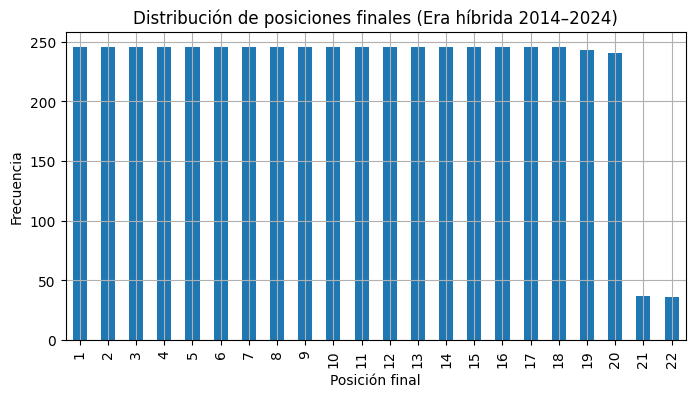

In [59]:
freq_modern = df_modern["positionOrder"].value_counts().sort_index()

freq_modern.plot(kind="bar")
plt.xlabel("Posición final")
plt.ylabel("Frecuencia")
plt.title("Distribución de posiciones finales (Era híbrida 2014–2024)")
plt.show()

## 4. Matriz de correlaciones (Figura 2)
Seleccionar variables numéricas clave y graficar.

,grid,positionOrder,points,laps
grid,1.000,0.581,-0.624,-0.085
positionOrder,0.581,1.000,-0.845,-0.479
points,-0.624,-0.845,1.000,0.244
laps,-0.085,-0.479,0.244,1.000


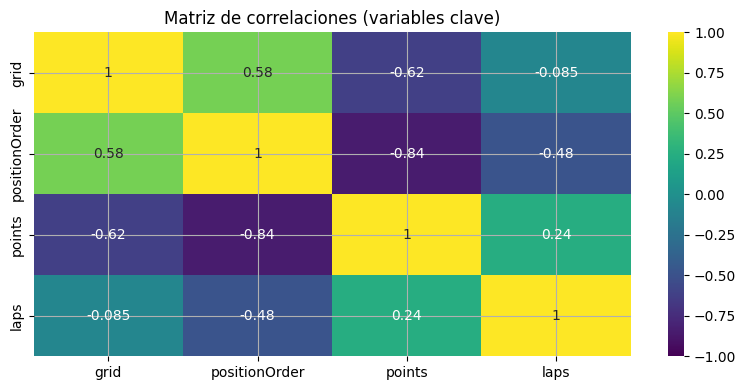

(4, 'variables exportadas')

In [60]:
# %% correlations
cols = [c for c in ['grid','positionOrder','points','laps'] if c in df_modern.columns]
corr = df_modern[cols].corr(method='pearson')
display(corr.round(3))

sns.heatmap(corr, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Matriz de correlaciones (variables clave)')
plt.tight_layout(); plt.show()

# Export para LaTeX en formato x y z (mesh/cols=len(cols))
table_lines = ['x y z']
for i, xi in enumerate(cols, start=1):
    for j, yj in enumerate(cols, start=1):
        table_lines.append(f"{i} {j} {corr.loc[xi, yj]:.2f}")
len(cols), 'variables exportadas'

## 5. Balance y fugas de información
- Proporciones por posición y por temporada.
- Confirmar que no se usan `standings` u otros campos con información posterior.


In [61]:
by_season = (df_modern.groupby('season')['positionOrder']
             .value_counts(normalize=True)
             .unstack(fill_value=0) if 'season' in df_modern.columns else pd.DataFrame())
display(by_season.head() if not by_season.empty else 'season no disponible')

leak_cols = [c for c in df_modern.columns if 'standing' in c.lower()]
leak_cols

positionOrder,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,22
season,,,,,,,,,,,,,,,,,,,,,
2014,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,...,0.046683,0.046683,0.046683,0.046683,0.046683,0.046683,0.041769,0.041769,0.039312,0.036855
2015,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,...,0.050265,0.050265,0.050265,0.050265,0.050265,0.050265,0.047619,0.047619,0.000000,0.000000
2016,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,...,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455,0.045455
2017,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.000000,0.000000
2018,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.000000,0.000000


[]

In [62]:
df_modern.shape[0]

4985

## 7. Exportación de artefactos
Guardar datasets y artefactos para LaTeX.


In [63]:
out_dir = Path('eda_outputs'); out_dir.mkdir(exist_ok=True)
df_modern.to_csv(out_dir / 'F1_cleaned_for_model.csv', index=False)
print('Exportado a', out_dir.resolve())

Exportado a /home/unnamedpilot/universidad/10mo/machine_learning/project/notebooks/eda_outputs


In [64]:
df["constructor_name"].unique()

array(['McLaren', 'BMW Sauber', 'Williams', 'Renault', 'Toro Rosso',
       'Ferrari', 'Toyota', 'Super Aguri', 'Red Bull', 'Force India',
       'Honda', 'Spyker', 'MF1', 'Spyker MF1', 'Sauber', 'BAR', 'Jordan',
       'Minardi', 'Jaguar', 'Arrows', 'Prost', 'Benetton', 'Stewart',
       'Tyrrell', 'Lola', 'Ligier', 'Footwork', 'Forti', 'Pacific',
       'Simtek', 'Team Lotus', 'Larrousse', 'Brabham', 'Dallara',
       'Fondmetal', 'March', 'Andrea Moda', 'Lambo', 'AGS',
       'Leyton House', 'Coloni', 'Euro Brun', 'Osella', 'Onyx', 'Life',
       'Brawn', 'Rial', 'Zakspeed', 'RAM', 'Alfa Romeo', 'Spirit',
       'Toleman', 'ATS', 'Theodore', 'Fittipaldi', 'Ensign', 'Shadow',
       'Wolf', 'Brabham-Alfa Romeo', 'Merzario', 'Kauhsen', 'Rebaque',
       'Brabham-Ford', 'Surtees', 'Hesketh', 'Martini', 'BRM', 'Penske',
       'LEC', 'McGuire', 'Boro', 'Apollon', 'Kojima', 'Parnelli', 'Maki',
       'Shadow-Ford', 'Embassy Hill', 'Lyncar', 'Shadow-Matra',
       'Iso Marlboro', 'Trojan'